In [340]:
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

plt.set_cmap('gray')
from sklearn.model_selection import KFold, cross_val_score, train_test_split

catsAndDogs = pd.read_csv('./CATSnDOGS.csv')
labels = np.ravel(pd.read_csv("./Labels.csv"))

<Figure size 640x480 with 0 Axes>

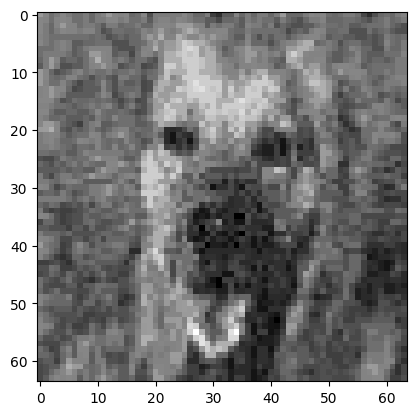

In [341]:
animal = catsAndDogs.loc[6]                   ## Retrieve animal at row
animal = animal.values.reshape((64,64)).T     ## Reshape to 64x64 and transpose to get correct orientation

plt.imshow(animal)
X_train_clean, X_test, y_train_clean, y_test = train_test_split(catsAndDogs, labels, test_size=0.2, random_state=1234567)


In [342]:
## Pollute Datasets
## Polluting at 2 different levels

def generatePollutedData(X,y,method,datasetPollution,pixelPollution,):
  pollutedX = X.copy()
  indexOfPollution = np.random.choice(np.arange(0,np.shape(X)[0],1),int(datasetPollution*np.shape(X)[0]),replace=False)

  if method == 0: #Remove Indexes of pollution
    pollutedX.Drop()
  elif method == 1: #Impute indexes of pollution
    print("error")

  elif method == 2: # Just return polluted dataset
    print("error")


In [343]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
#Define all models

def Random_forest(X_train,y_train):
  estimator_range = range(10, 101, 10)

  cv_scores = []

  for n_estimators in estimator_range:
      clf_rf = RandomForestClassifier(n_estimators=n_estimators)
      scores = cross_val_score(clf_rf, X_train, y_train, cv=5, scoring='accuracy')
      cv_scores.append(scores.mean())
  optimal_n = estimator_range[cv_scores.index(max(cv_scores))]
  # Create Random Forest classifier and fit the model
  clf_rf = RandomForestClassifier(n_estimators=optimal_n) ## Tuneable parameters. Cross validation?
  clf_rf.fit(X_train, y_train)

  # Predict test set and calculate accuracy
  y_pred_rf = clf_rf.predict(X_test)
  accuracy_rf = accuracy_score(y_test, y_pred_rf)
  mislabelled_rf = np.where(y_pred_rf != y_test)[0]
  
  return accuracy_rf, mislabelled_rf

def LDAClassification(X_train,y_train):
  clf = LDA()
  clf.fit(X_train, y_train)
  y_pred = clf.predict(X_test)
  # Save variable for plot
  #visualize(X_test,color=y_pred,title=f"LDA, frac mislabelled = {fraction}")
  accuracy = accuracy_score(y_test, y_pred)
  mislabelled_LDA = np.where(y_pred != y_test)[0]

  importances = clf.coef_[0]

  return accuracy, importances, mislabelled_LDA  

def knnClassification(X_train,y_train):

  # Define k-fold cross validation object
  k_values = list(range(1, 20))
  num_folds = 10
  kf = KFold(n_splits=num_folds, shuffle=True)
  mean_scores = [] # Will contain the mean cross validation scores for each k value


  # Loop over k values to test
  for k in k_values:
      # Create kNN classifier with k neighbors
      knn = KNeighborsClassifier(n_neighbors=k)
      
      # Use cross_val_score to perform k-fold cross validation and calculate mean accuracy
      scores = cross_val_score(knn, X_train, y_train, cv=kf, scoring='accuracy')
      mean_scores.append(np.mean(scores))

  best_k = k_values[np.argmax(mean_scores)]
  print(f"Best k value: {best_k}")


  # Evaluate the classifier on the test set
  knn = KNeighborsClassifier(n_neighbors=best_k)
  knn.fit(X_train, y_train)
  y_pred = knn.predict(X_test)
  
  mislabelled_knn = np.where(y_pred != y_test)[0]
  
  accuracy = accuracy_score(y_test, y_pred)

  # TSNE plot
  #visualize(X_test,color=y_pred,title=f"KNN, frac mislabelled = {fraction}")
  return accuracy, mislabelled_knn

In [344]:
##MASTER SCRIPT
#input arguments: train data, train label,test data, test label, number of runs, Title for Bar (string!)

def generate_bar(X_train,y_train,X_test,y_test,number_of_runs,title):

  X_train_data = X_train
  y_train_data = y_train
  #Generate data for Random Forest
  forest_runs = []

  for run in range(number_of_runs):
    forest_runs.append(Random_forest(X_train_data,y_train_data))
  forest_performance = sum(forest_runs)/number_of_runs

  #Generate data for KNN
  KNN_runs = []
  for run in range(number_of_runs):
    KNN_runs.append(knnClassification(X_train_data,y_train_data)) 

  KNN_performance = sum(KNN_runs)/number_of_runs

  #generate data for LDA
  LDA_runs = []
  for run in range(number_of_runs):
    LDA_runs.append(LDAClassification(X_train_data,y_train_data)[0])
  LDA_performance = sum(LDA_runs)/number_of_runs


  #generate bar diagram
  objects = ('Python', 'C++', 'Java', 'Perl', 'Scala', 'Lisp')
  y_pos = np.arange(len(objects))
  performance = [forest_performance,KNN_performance,LDA_performance]

  plt.bar(range(3),performance, align='center', alpha=0.5)
  plt.xticks(range(3),['Random Forest','KNN','LDA'])
  plt.ylabel('Correct classifications')
  plt.title(title)
  plt.show()

In [345]:
# generate_bar(X_train_clean,y_train_clean,X_test,y_test,10,"Model Perfomance on Cats and Dogs")

Examine commonly mislabelled images

Best k value: 3
Mislabelled RF: 8 [ 0  2  6  7 12 22 29 35]
Mislabelled KNN: 8 [ 2  4 11 12 27 28 29 34]
Mislabelled LDA: 5 [ 2  4 22 23 35]
Mislabelled by two or more: 6 [ 2  4 12 22 29 35]
Mislabelled unique: 14 [ 0  2  4  6  7 11 12 22 23 27 28 29 34 35]


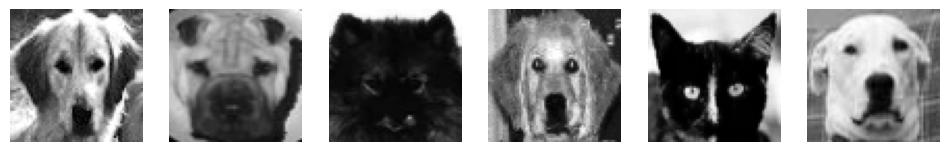

In [346]:
mislabelled_rf = Random_forest(X_train_clean,y_train_clean)[1]
mislabelled_knn = knnClassification(X_train_clean,y_train_clean)[1]
mislabelled_LDA = LDAClassification(X_train_clean,y_train_clean)[2]

print("Mislabelled RF:", len(mislabelled_rf), mislabelled_rf)
print("Mislabelled KNN:", len(mislabelled_knn), mislabelled_knn)
print("Mislabelled LDA:", len(mislabelled_LDA), mislabelled_LDA)

intersect1_2 = np.intersect1d(mislabelled_rf, mislabelled_knn)
intersect1_3 = np.intersect1d(mislabelled_rf, mislabelled_LDA)
intersect2_3 = np.intersect1d(mislabelled_knn, mislabelled_LDA)
union_temp = np.union1d(intersect1_2, intersect1_3)
union_final = np.union1d(union_temp, intersect2_3)
print("Mislabelled by two or more:", len(union_final), union_final)

mislabelled_unique = np.unique(np.concatenate((mislabelled_rf, mislabelled_knn, mislabelled_LDA), axis=0))
print("Mislabelled unique:", len(mislabelled_unique), mislabelled_unique)

image_indices = union_final

f, ax = plt.subplots(1,len(image_indices), figsize=(12,12))
    
for i,j in enumerate(image_indices):
    ax[i].imshow(catsAndDogs.loc[j].values.reshape((64,64)).T)
    ax[i].axis('off') 

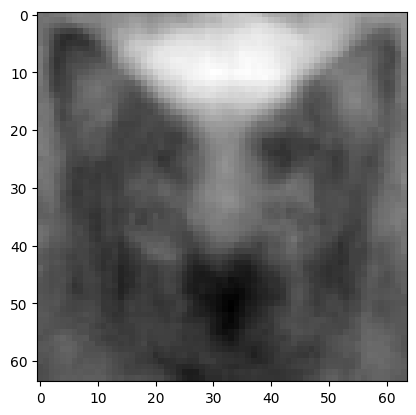

In [347]:
## Single Value Decomposition
from sklearn.decomposition import TruncatedSVD
tsvd = TruncatedSVD(n_components=2)            # Create matrix of 20 components

datasetTSVD = tsvd.fit_transform(catsAndDogs)   # Fit data to said 20 components
datasetTSVD_reconstructed = tsvd.inverse_transform(datasetTSVD) # Invert transform to original dimensions

testVisualisation = np.reshape(datasetTSVD_reconstructed[6],(64,64)).T
plt.imshow(testVisualisation)


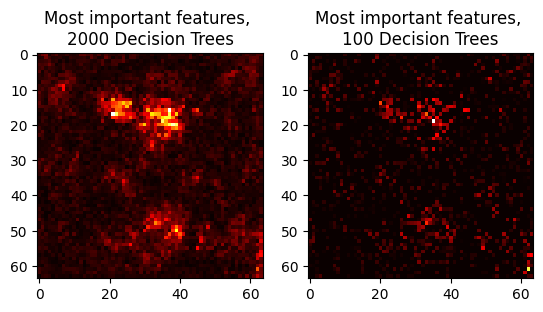

In [348]:
## Random Forest Feature Importance
forest = RandomForestClassifier(n_estimators=2000,random_state=1234567)
forest.fit(X_train_clean, y_train_clean)

featureImportances = forest.feature_importances_
weight_vector = featureImportances.copy()
featureImportances = np.reshape(featureImportances,(64,64)).T

plt.subplot(1,2,1)
plt.title("Most important features, \n2000 Decision Trees")
plt.imshow(featureImportances, cmap="hot")

## Once again for a lower set of n_estimators
forest = RandomForestClassifier(n_estimators=100,random_state=1234567)
forest.fit(X_train_clean, y_train_clean)

featureImportances = forest.feature_importances_
featureImportances = np.reshape(featureImportances,(64,64)).T

plt.subplot(1,2,2)
plt.title("Most important features, \n100 Decision Trees")
plt.imshow(featureImportances,cmap="hot")


### Theme 2a ###

In [349]:
# Define function to visualize pollution 
def visualize_pollution(image_indices, polluted_images):      
    plt.subplot(2,2,1)
    plt.imshow(polluted_images.loc[image_indices[0]].values.reshape((64,64)).T)
    plt.axis('off')
    plt.subplot(2,2,2)
    plt.imshow(polluted_images.loc[image_indices[1]].values.reshape((64,64)).T)
    plt.axis('off')
    plt.subplot(2,2,3)
    plt.imshow(polluted_images.loc[image_indices[2]].values.reshape((64,64)).T)
    plt.axis('off')
    plt.subplot(2,2,4)
    plt.imshow(polluted_images.loc[image_indices[3]].values.reshape((64,64)).T)
    plt.axis('off')
    plt.tight_layout()

Pollute random fraction of the pixels of a random fraction of the images

NaN in original data: 0
NaN in polluted data: 19


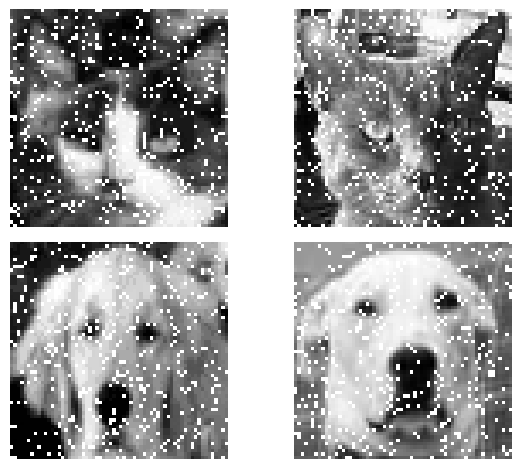

In [350]:
image_fraction = 0.1
pixel_fraction = 0.1

random_images = np.random.choice(catsAndDogs.shape[0], int(image_fraction*catsAndDogs.shape[0]), replace=False)

polluted_images = catsAndDogs.copy()

for i in random_images:
    im = catsAndDogs.loc[i]
    
    random_pixels = np.random.choice(4096, int(pixel_fraction*4096), replace=False) 
    
    im[random_pixels] = np.nan
    polluted_images.loc[i] = im

# Verify number of rows with NaN values
print('NaN in original data:', catsAndDogs.isnull().any(axis=1).sum())
print('NaN in polluted data:', polluted_images.isnull().any(axis=1).sum())

random_plot_images = np.random.choice(random_images, 4, replace=False)

visualize_pollution(random_plot_images, polluted_images)


Removing images with missing pixels

In [351]:
# Remove rows with NaN values
print('Images before pruning:', polluted_images.shape[0])
X_train_dropna = polluted_images.dropna(axis='rows')
print('Images after pruning:', X_train_dropna.shape[0])

## Do classification


Images before pruning: 198
Images after pruning: 179


Imputation

In [352]:
from sklearn.impute import SimpleImputer # univariate imputation
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imputed = mean_imputer.fit_transform(polluted_images)

from sklearn.impute import KNNImputer
kNN_imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train_kNN_imputed = kNN_imputer.fit_transform(polluted_images)

In [353]:
# Define function to compare resulting imputed image to original and polluted
def visualize_imputations(image_indices, polluted_images, X_train_mean_imputed, X_train_kNN_imputed):
    for i in image_indices:
        original = catsAndDogs.loc[i].values.reshape((64,64)).T
        polluted = polluted_images.loc[i].values.reshape((64,64)).T
        mean_imputed = X_train_mean_imputed[i].reshape((64,64)).T
        kNN_imputed = X_train_kNN_imputed[i].reshape((64,64)).T
        
        f, ax = plt.subplots(1,4, figsize=(16,16))
        ax[0].imshow(polluted)
        ax[0].set_title('Polluted')
        ax[0].axis('off')
        
        ax[1].imshow(mean_imputed)
        ax[1].set_title('Imputed (mean)')
        ax[1].axis('off')
        
        ax[2].imshow(kNN_imputed)
        ax[2].set_title('Imputed (kNN)')
        ax[2].axis('off')

        ax[3].imshow(original)
        ax[3].set_title('Original')
        ax[3].axis('off')
        plt.show()

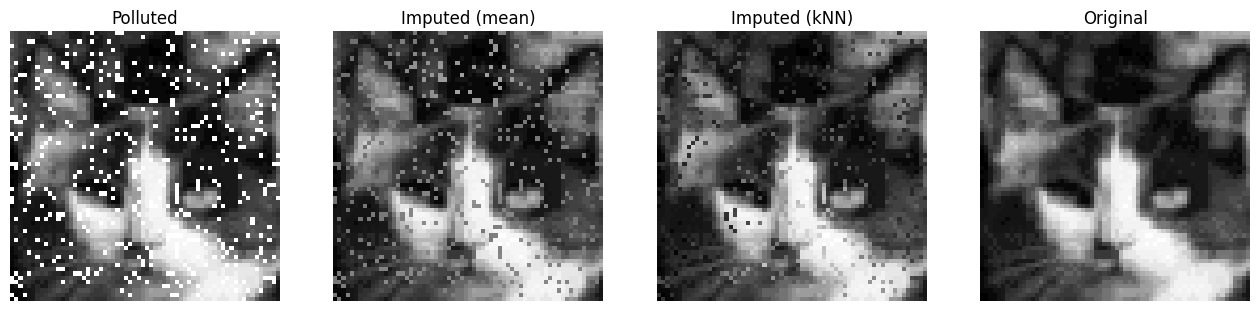

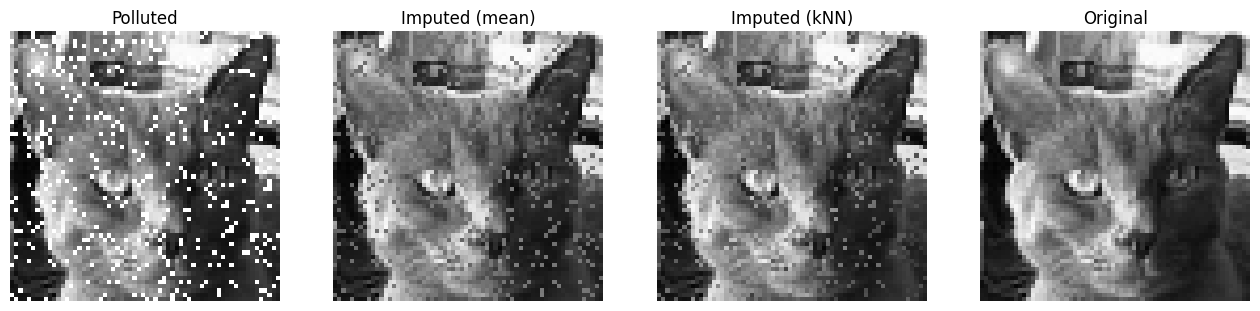

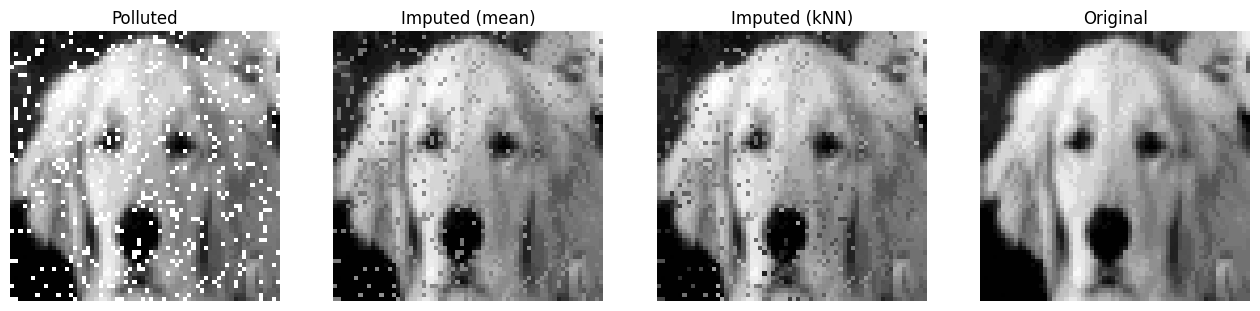

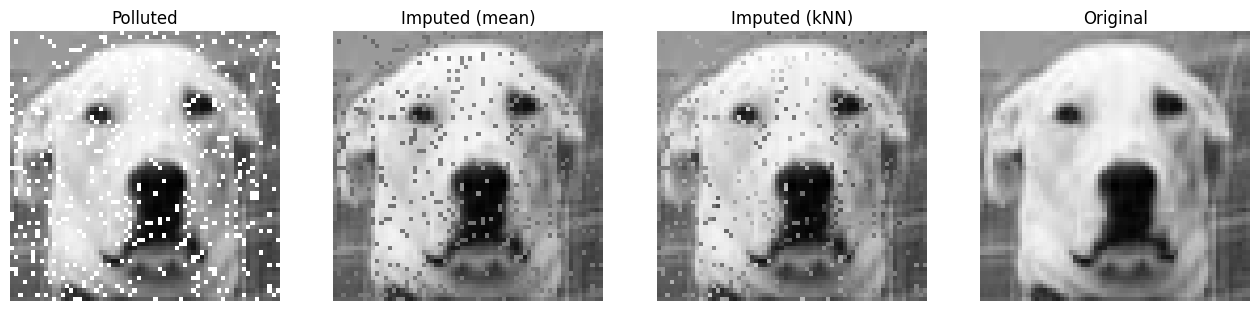

In [354]:
visualize_imputations(random_plot_images, polluted_images, X_train_mean_imputed, X_train_kNN_imputed)

Remove a random fraction of the significant pixels for a random subset of the images

NaN in original data: 0
NaN in polluted data: 19


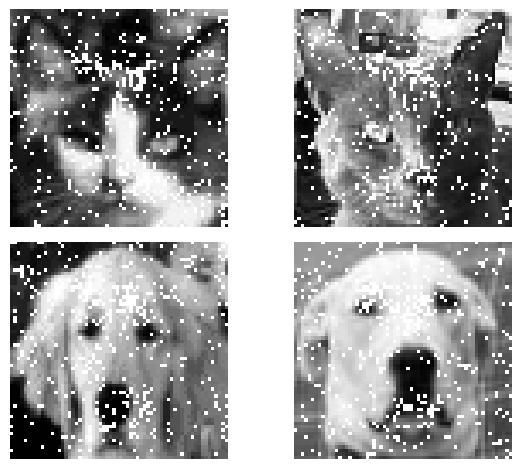

In [355]:
image_fraction = 0.1
pixel_fraction = 0.1

polluted_images = catsAndDogs.copy()

for i in random_images:
    im = catsAndDogs.loc[i]
    
    random_pixels = np.random.choice(4096, int(pixel_fraction*4096), replace=False, p = weight_vector) # 2000 estimators
    
    im[random_pixels] = np.nan
    polluted_images.loc[i] = im

# Verify number of rows with NaN values
print('NaN in original data:', catsAndDogs.isnull().any(axis=1).sum())
print('NaN in polluted data:', polluted_images.isnull().any(axis=1).sum())

visualize_pollution(random_plot_images, polluted_images)

Univariate and kNN imputation

In [356]:
# Cleaning the data with different types of imputation 
from sklearn.impute import SimpleImputer # univariate imputation
mean_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
X_train_mean_imputed = mean_imputer.fit_transform(polluted_images)

from sklearn.impute import KNNImputer
kNN_imputer = KNNImputer(n_neighbors=2, weights="uniform")
X_train_KNN_imputed = kNN_imputer.fit_transform(polluted_images)

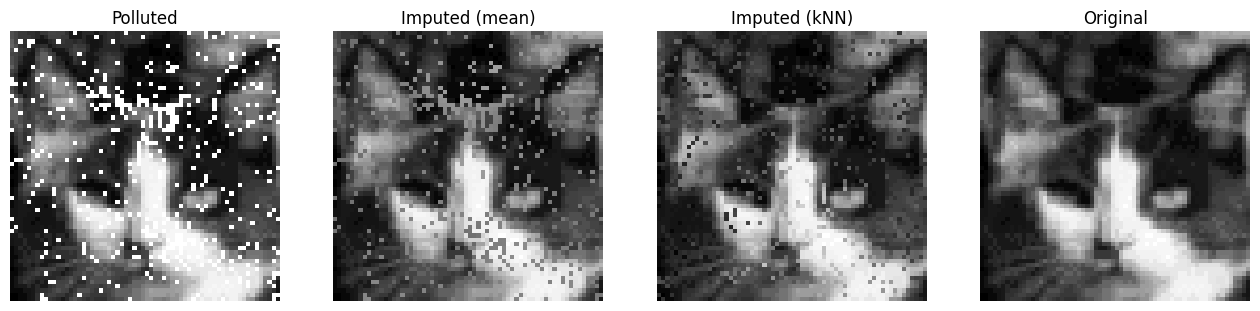

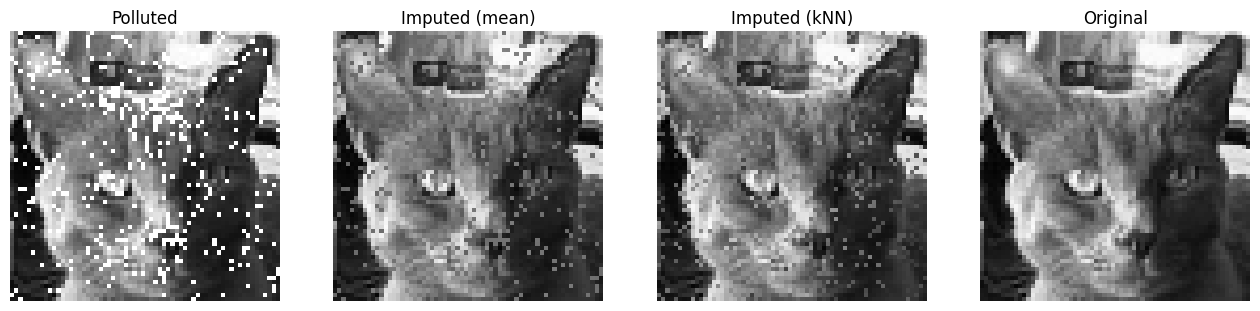

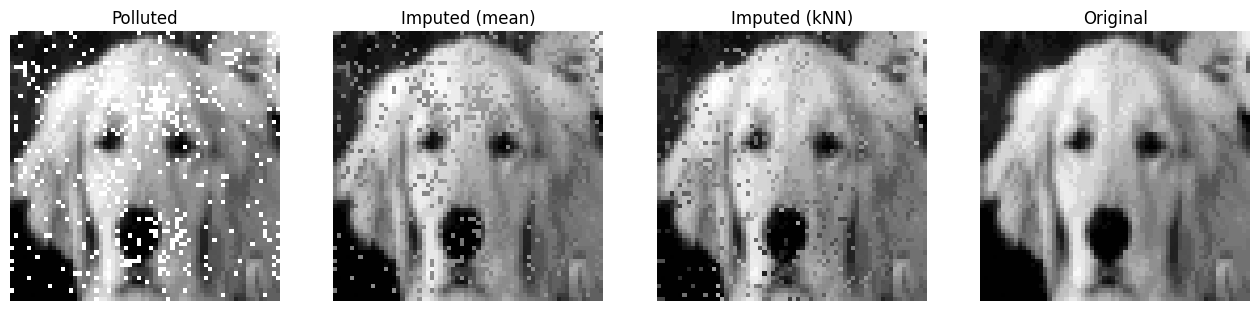

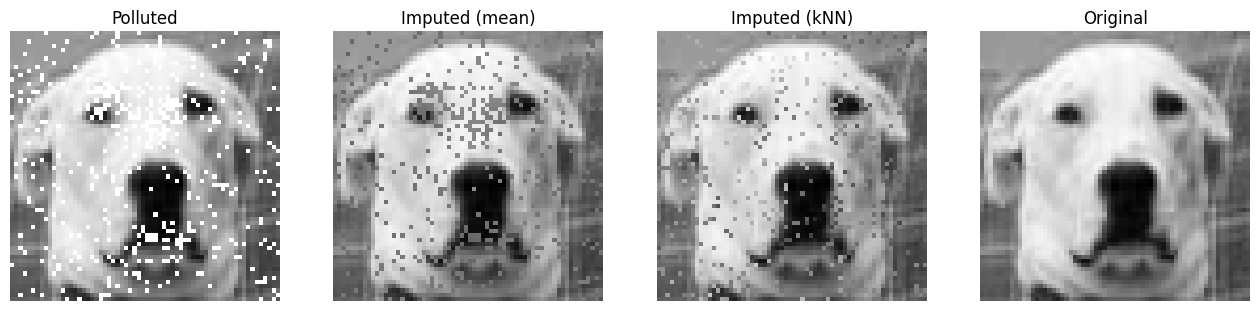

In [357]:
visualize_imputations(random_plot_images, polluted_images, X_train_mean_imputed, X_train_kNN_imputed)